In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def f(x):
    return 3*x**2 - 4*x + 5

In [5]:
f(3.0)

20.0

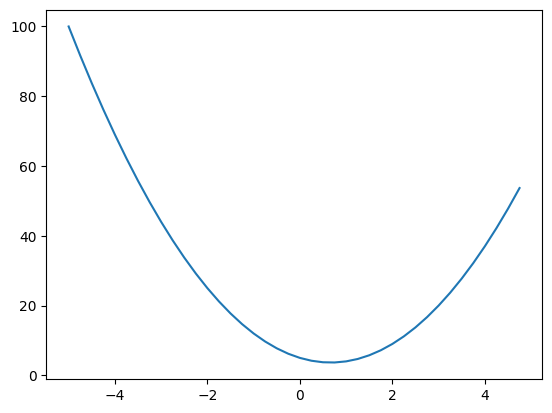

In [6]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [7]:
h = 0.0000001
x = 2/3
(f(x + h) - f(x))/h
# simply a demonstrative function, inflection at x = 2/3

2.9753977059954195e-07

In [8]:
# added complexity
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [9]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

# demonstrating slope
d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [151]:
# define a skeleton Value class
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    #overload arithmetic operators    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+' )
        
        def _backward():
            self.grad += 1.0 * out.grad # from chain rule
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*' )
        
        def _backward():
            self.grad += other.data * out.grad # chain rule   
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supports int/float powers atm"
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad # calculus power rule plus chain rule :-)
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # fallback for cases such as 2 * Value
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    #implement tanh
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad # more chain rule
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    

    def backward(self):
        
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
            
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f; L.label = 'L'
d

Value(data=4.0)

In [142]:
2 * a + 1

Value(data=5.0)

In [150]:
a/b

Value(data=-0.6666666666666666)

In [13]:
# tracking _prev and _op allow us to know exactly which values
# and operation led to the current Value

In [18]:
# create helper viz functions using graphviz api
from graphviz import Digraph

In [27]:
 def trace(root):
  # build a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any val in graph, create rectangular ('record') node
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad ), shape='record')
    if n._op:
      # if this val is a result of an operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # then connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

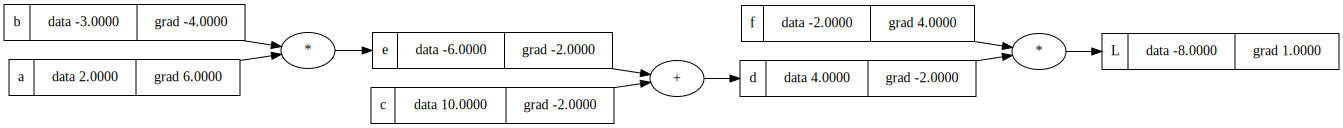

In [47]:
draw_dot(L)

In [44]:
# manual backpropagation
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0

In [46]:
# at this point, added grad to the Value class to track & viz backpropagation

L.grad = 1.0 

a.grad  = -2.0 * -3.0
b.grad = -2.0 * 2.0


In [49]:
# manual nudge toward gradient to improve L
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-6.586368000000001


In [42]:
# create gating function (so as to not pollute global scope)
def lol():
    h = 0.0001
    
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    d.data += h
    f = Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'
    L2 = L.data
    
    # printing slope
    print((L2 - L1)/h)
    
lol()

-1.9999999999953388


In [43]:
# !!! we need to derive dL / dc !!!

# dd / dc ? 1.0
# d = c + e
# ((c+h + e) - (c + e)) / h
# (c + h + e - c - e) / h
# local derivative of d with respect to c

# dz / dx = (dz / dy) * (dy / dx)
# ^^^ this is the chain rule

# to find the effect of dL / dc, we repeatedly multiply the local gradient per operation as we trace the graph

In [54]:
######### backpropagating a neuron by hand #########

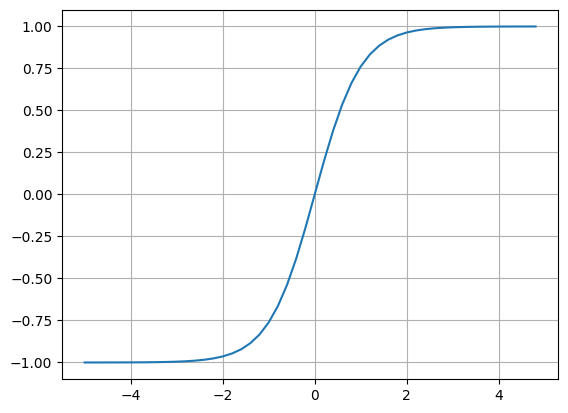

In [52]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

In [53]:
# tanh squashes the inputs to fit approach 1 and -1 but scale properly in between

In [156]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# inherent bias of neuron
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

#at this point, implement tanh() in Value class

o = n.tanh(); o.label = 'o'

In [106]:
# n.grad = 0.5

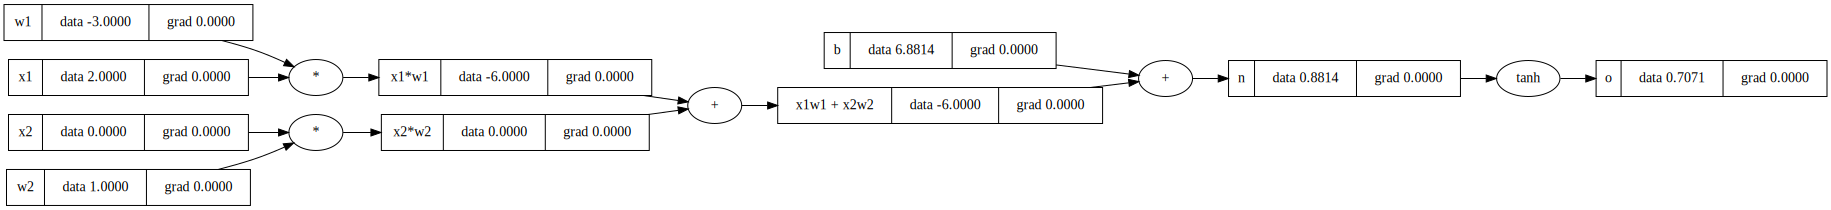

In [157]:
draw_dot(o)

In [82]:
x1.grad = w1.data * x1w1.grad
w2.grad = x1.data * x1w1.grad

In [79]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [76]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [74]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [69]:
o.grad = 1.0

In [71]:
1 - o.data**2

0.4999999999999999

In [84]:
# o = tanh(n)
# do/dn = 1 - o**2

In [85]:
# implementing backpropagation programatically

In [158]:
# added self._backward to Value class
o.grad = 1.0

In [159]:
o._backward()

In [160]:
n._backward()

In [161]:
b._backward()

In [162]:
x1w1x2w2._backward()


In [163]:
x2w2._backward()
x1w1._backward()

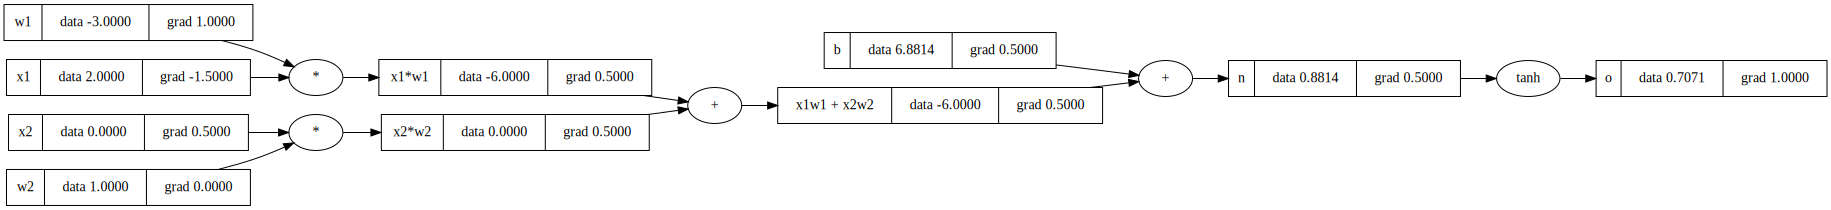

In [164]:
draw_dot(o)

In [127]:
# finally, just automatically calculate backward values
# we'll organize the graph via topological sort, defined here:
topo = []
visited = set()

In [128]:
build_topo(o) # note that we set the base case o.grad = 1.0
topo

[Value(data=6.881373587019543),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [155]:
o.backward()